In [18]:
from sklearn.ensemble import GradientBoostingRegressor
import pre_process, load_data
from feature_extraction import get_win_feats
from scipy.stats import pearsonr
from scipy.ndimage import gaussian_filter1d
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import numpy as np
from scipy.io import savemat

val, train = load_data.split_train_val("raw_training_data.mat",0.3)

predictions = np.zeros((3,1), dtype=object)

val[0][0] = np.delete(val[0][0],[54],1)
train[0][0] = np.delete(train[0][0],[54],1)

val[0][1] = np.delete(val[0][1],[20,37],1)
train[0][1] = np.delete(train[0][1],[20,37],1)

mean_corr = []
predictions = np.zeros((3,1), dtype=object)

for i in range(3):
    print("subject {}".format(i+1))
    corr = []
    corr_lst = []
    pred_finger = []
    for j in range(5):
        reg = GradientBoostingRegressor(n_estimators=100)
        train_x, train_y = pre_process.filter_data(train[0][i]), train[1][i][:, j] 
        val_x, val_y = pre_process.filter_data(val[0][i]),val[1][i][:, j]
        train_y_down = pre_process.downsample(int(25*train_y.shape[0]/1000),train_y)
        val_y_down = pre_process.downsample(int(25*val_y.shape[0]/1000),val_y)
        feature_train = get_win_feats.get_windowed_feats(train_x,1000,80,40)
        feature_val = get_win_feats.get_windowed_feats(val_x,1000,80,40)
        reg.fit(feature_train,pre_process.downsample(feature_train.shape[0],train_y_down))
        pred = reg.predict(feature_val)
        scaler = MinMaxScaler((-1,2))
        pred = pred.reshape(-1, 1)
        pred_ = scaler.fit_transform(gaussian_filter1d(pred,sigma=4,axis=0))
        thre = 0
        pred__ = pred_.copy()
        for m in range(pred__.shape[0]):
            for n in range(pred__.shape[1]):
                if pred__[m,n]>thre:
                    pred__[m,n]*=2
        pred_finger.append(pre_process.upsample(val_y.shape[0],pred__).reshape(-1))
        corr = pearsonr(pre_process.upsample(val_y.shape[0], pred__).reshape(-1), val_y)[0]
        corr_lst.append(corr)
        print('Finger {}'.format(j+1),corr)
    print('---------------------------------------------')
    predictions[i,0] = np.vstack(pred_finger).T
    mean_corr.append(np.mean(corr_lst))
    print(np.mean(corr_lst))

print('overall mean:',np.mean(mean_corr))

subject 1
Finger 1 0.5672822710240513
Finger 2 0.6910144470171811
Finger 3 0.1925792291768469
Finger 4 0.537902143232901
Finger 5 0.22297598672261587
---------------------------------------------
0.4423508154347192
subject 2
Finger 1 0.6397265158590317
Finger 2 0.35988312166739833
Finger 3 0.4013198159396162
Finger 4 0.5810954571299987
Finger 5 0.3384878614418082
---------------------------------------------
0.46410255440757064
subject 3
Finger 1 0.786845892279661
Finger 2 0.724686387350435
Finger 3 0.6105945442266643
Finger 4 0.792803584907519
Finger 5 0.3276970890929264
---------------------------------------------
0.6485254995714411
overall mean: 0.518326289804577


In [21]:
#find the time of movement
import pre_process
import numpy as np
from scipy.ndimage import gaussian_filter1d

def move_time(y):
    '''
    Input:
     y: digital glove data of a subject
    Output:
     start, stop: lists of 5 arrays.
    '''
    y_ = pre_process.downsample(int(25*y.shape[0]/1000),y)
    filt_y = gaussian_filter1d(y_,sigma = 5,axis = 0) # filtration with Gaussian
    start,stop = [],[]
    for i in range(5):
        thres = np.where(filt_y[:,i]>=0.5)[0]
        start_idx = []
        for j in range(thres.shape[0]):
            if filt_y[thres[j],i]>=0.5 and filt_y[thres[j]-1,i]<0.5:
                start_idx.append(thres[j])
        stop_idx = []
        for j in range(len(start_idx)):
            if np.any(filt_y[start_idx[j]:,i]<0):
                stop_idx.append(start_idx[j]+np.min(np.where(filt_y[start_idx[j]:,i]<=0)[0]))
            else: 
                stop_idx.append(filt_y.shape[0])
        a = np.where(np.diff(stop_idx,1)==0)[0]
        start_idx_=start_idx.copy()
        stop_idx_ = stop_idx.copy()
        for i in range(a.shape[0]):
            start_idx_.remove(start_idx[a[i] +1])
            stop_idx_.remove(stop_idx[a[i]])
        start.append(np.array(start_idx_)*40) #supersample back
        stop.append(np.array(stop_idx_)*40) #supersmaple bacl
    return start,stop


def label_glove(y):
    '''
    Input:
     y: digital glove data of a subject
    Output:
     labels of movement of each finger by 40ms window (1 for move, 0 for rest).
    '''
    start,stop = move_time(y)
    labels = []
    for i in range(5):
        label = []
        start_temp,stop_temp=start[i],stop[i]
        N = start_temp.shape[0]
        if start_temp.shape[0]>0:
            for j in range(N):
                if j ==0:
                    label+=[0]*int(start_temp[j]/40)
                    label+=[1]*int((stop_temp[j]-start_temp[j])/40)
                else:
                    label+=[0]*int((start_temp[j]-stop_temp[j-1])/40)
                    label+=[1]*int((stop_temp[j]-start_temp[j])/40)
            label+=[0]*int((y.shape[0]-stop_temp[-1])/40)
        else:
            label = [0]*int(y.shape[0]/40)
        labels.append(np.array(label))
    return np.vstack(labels).T

In [25]:
predictions[0][0]

array([[-0.66391715, -0.51424803, -0.24131308,  1.8615972 , -0.04970847],
       [-0.663913  , -0.51390353, -0.24093648,  1.8617284 , -0.0492084 ],
       [-0.6639097 , -0.51353959, -0.24053956,  1.8618685 , -0.04871355],
       ...,
       [-0.26619899,  1.30170024, -0.64395227, -0.39577345, -0.45454589],
       [-0.26597508,  1.30115325, -0.64369571, -0.39576348, -0.45417813],
       [-0.26574083,  1.30057685, -0.64342583, -0.39574141, -0.45379211]])

<Figure size 1400x500 with 0 Axes>

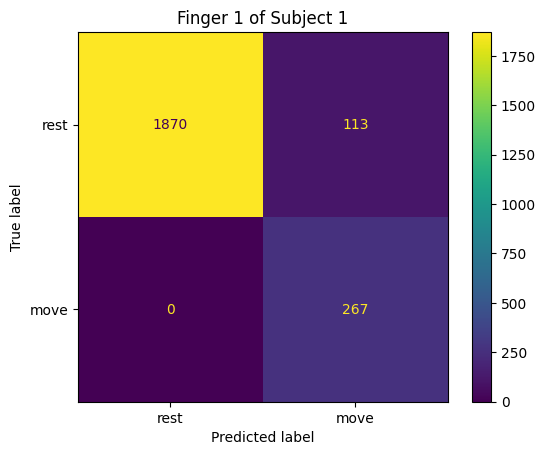

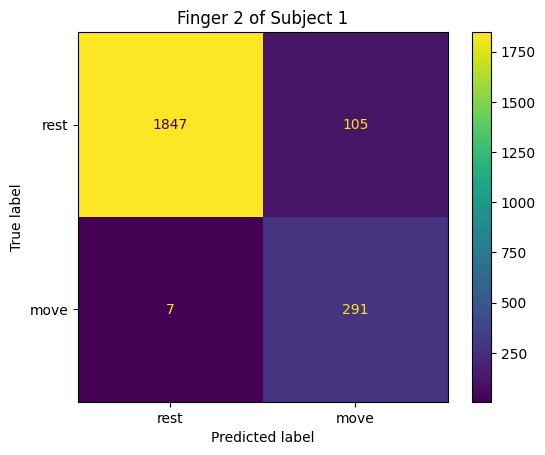

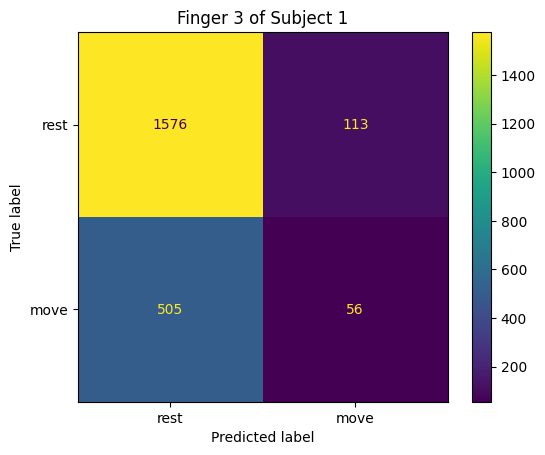

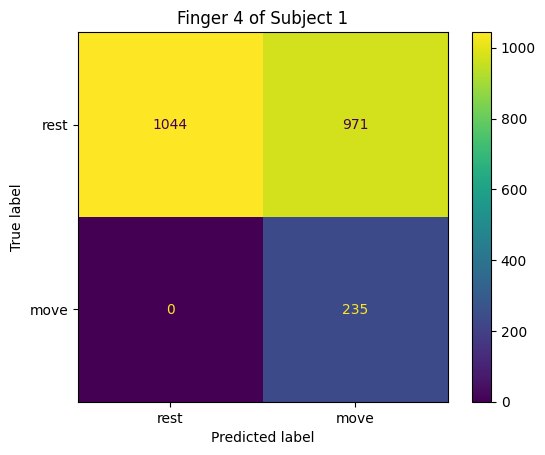

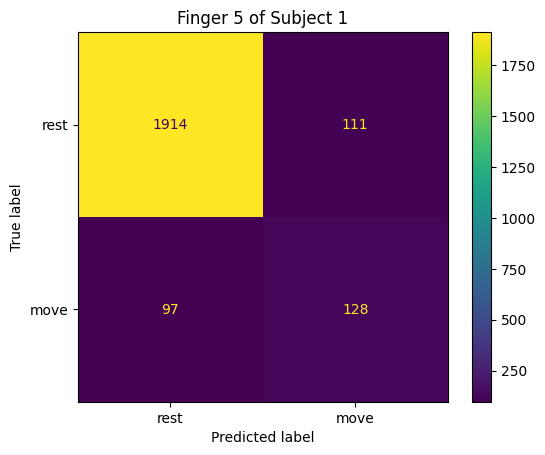

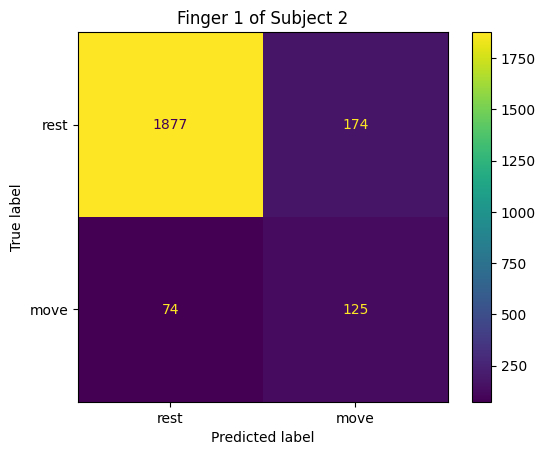

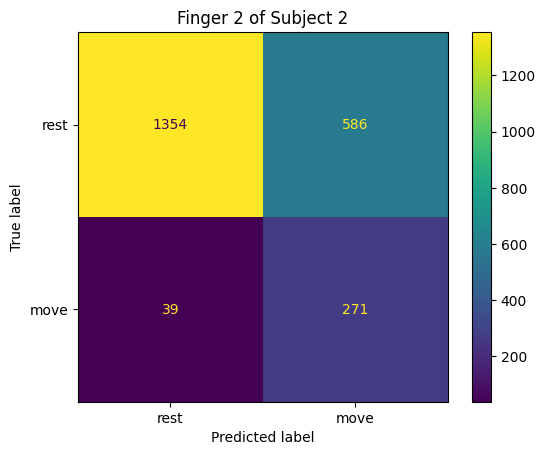

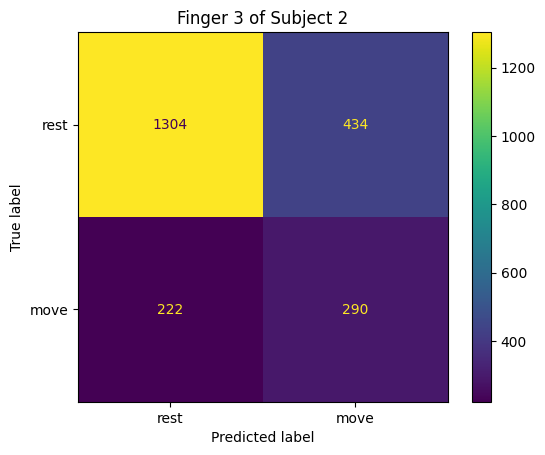

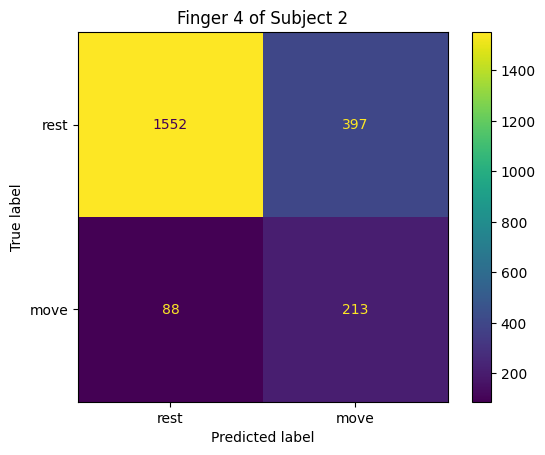

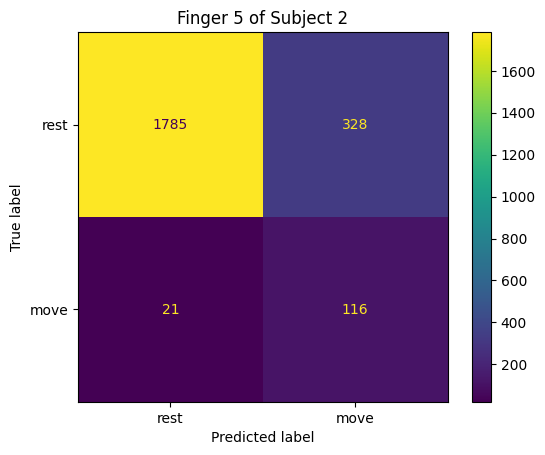

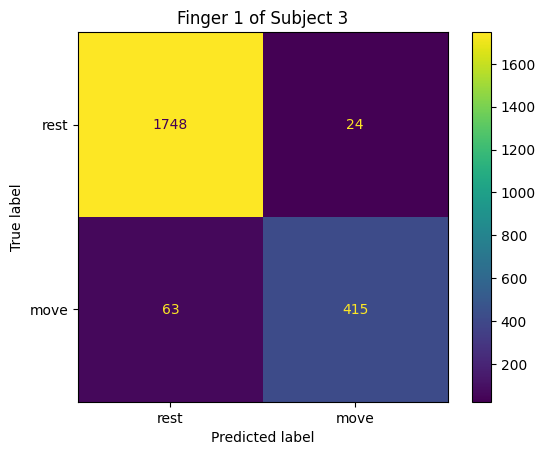

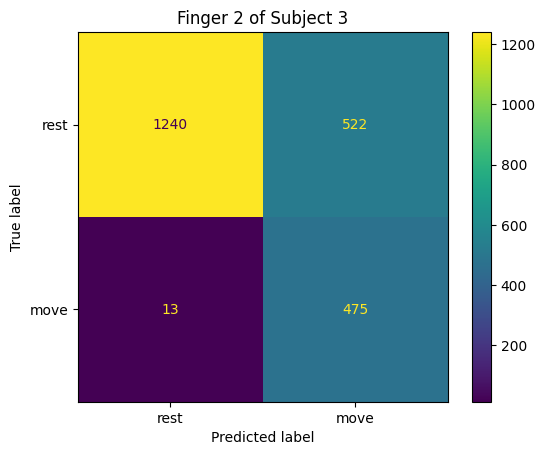

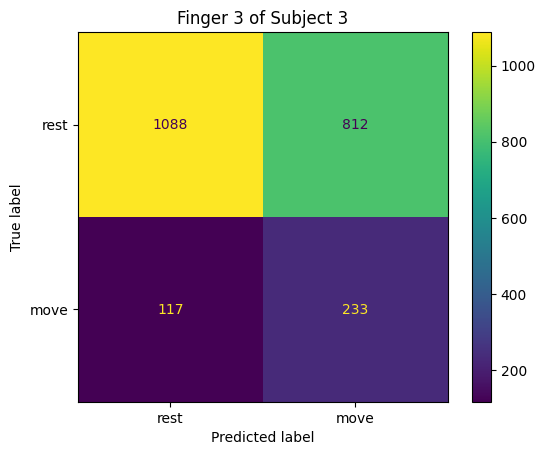

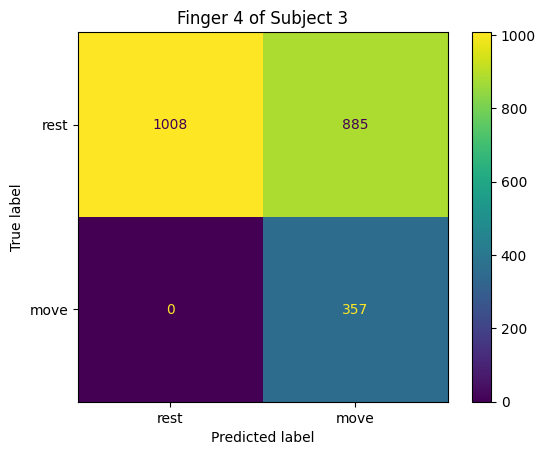

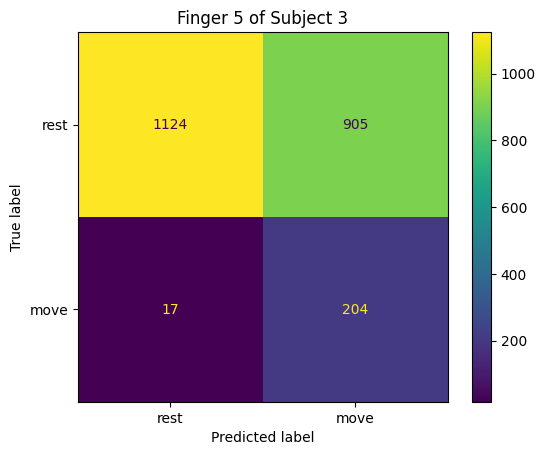

In [26]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from matplotlib import pyplot as plt
plt.figure(figsize=(14,5))
for i in range(3):
    label= label_glove(predictions[i][0])
    label_true = label_glove(val[1][i])
    for j in range(5):
        cm = confusion_matrix(label_true[:,j],label[:,j])
        disp = ConfusionMatrixDisplay(cm,display_labels=['rest','move'])
        #plt.subplot(5,3,i*5+j+1)
        disp.plot()
        disp.ax_.set_title('Finger {} of Subject {}'.format(j+1,i+1))
    #plt.title('recall and precision for subject {}'.format(i+1))
plt.show()

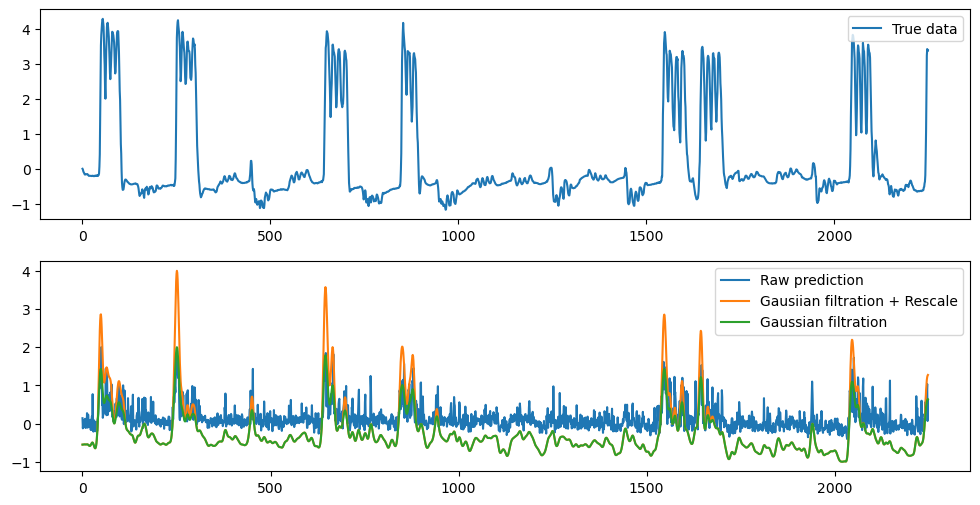

In [27]:
plt.figure(figsize=(12,6))
plt.subplot(211)
plt.plot(val_y_down[:,0],label = 'True data')
plt.legend(loc = 'upper right')
plt.subplot(212)
plt.plot(pred[:,0], label = 'Raw prediction')
plt.plot(pred__[:,0], label='Gausiian filtration + Rescale')
plt.plot(pred_[:,0],label = 'Gaussian filtration')
plt.legend()